In [1]:
import os
import re
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import math as math

from glob import glob
from collections import OrderedDict
from scipy.optimize import least_squares
from scipy.optimize import curve_fit

# Datos biblio

In [90]:
data="""
2.000E-02 6.059E-01 1.098E-01 3.308E+01 0.000E+00 3.380E+01 
3.000E-02 3.369E-01 1.231E-01 1.045E+01 0.000E+00 1.091E+01 
4.000E-02 2.124E-01 1.289E-01 4.520E+00 0.000E+00 4.862E+00 
5.000E-02 1.467E-01 1.311E-01 2.335E+00 0.000E+00 2.613E+00 
6.000E-02 1.079E-01 1.313E-01 1.353E+00 0.000E+00 1.593E+00 
8.000E-02 6.595E-02 1.295E-01 5.676E-01 0.000E+00 7.630E-01 
1.000E-01 4.446E-02 1.262E-01 2.878E-01 0.000E+00 4.585E-01 
1.500E-01 2.111E-02 1.171E-01 8.345E-02 0.000E+00 2.217E-01 
2.000E-01 1.226E-02 1.088E-01 3.487E-02 0.000E+00 1.559E-01 
3.000E-01 5.621E-03 9.581E-02 1.051E-02 0.000E+00 1.119E-01 
4.000E-01 3.207E-03 8.626E-02 4.664E-03 0.000E+00 9.413E-02 
5.000E-01 2.068E-03 7.899E-02 2.568E-03 0.000E+00 8.363E-02 
6.000E-01 1.442E-03 7.319E-02 1.621E-03 0.000E+00 7.625E-02 
8.000E-01 8.152E-04 6.441E-02 8.265E-04 0.000E+00 6.606E-02 
1.000E+00 5.228E-04 5.797E-02 5.143E-04 0.000E+00 5.901E-02 
1.022E+00 5.007E-04 5.735E-02 4.885E-04 0.000E+00 5.834E-02 
1.250E+00 3.351E-04 5.187E-02 3.303E-04 8.020E-05 5.261E-02 
1.500E+00 2.329E-04 4.716E-02 2.380E-04 4.024E-04 4.803E-02
"""

# Dividir los datos en cada columna
columna1 = []
columna2 = []
columna3 = []
columna4 = []
columna5 = []
columna6 = []

for linea in data.split('\n'):
    if linea.strip() != '':
        valores = linea.split()
        columna1.append(float(valores[0]))
        columna2.append(float(valores[1]))
        columna3.append(float(valores[2]))
        columna4.append(float(valores[3]))
        columna5.append(float(valores[4]))
        columna6.append(float(valores[5]))
# Crear arrays numpy para cada columna
E_biblio_2 = np.array(columna1)*1e3
rayleigh = np.array(columna2)*100 #los datos estan en cm2/g
Compton_dat = np.array(columna3)*100
fotoelectrico = np.array(columna4)*100
prod_pares = np.array(columna5)*100
at_total = np.array(columna6)*100

# Aca parece que si

In [14]:
def compton(x, b):

    k=x/511

    tau= b*(((((1+k)/(k)**2)*((2*(1+k)/(1+2*(k)))-np.log(1+2*(k))/(k))))+np.log(1+2*(k))/(2*(k))-(1+3*(k))/(1+2*(k))**2)

    return tau

def photo(x, a):

    k=x/511
    
    sigma=(a)*29**5/((k)**(3.5))

    return sigma

In [15]:
def FC(x,a,b):
  
  k=x/511

  tau= b*(((((1+k)/(k)**2)*((2*(1+k)/(1+2*(k)))-np.log(1+2*(k))/(k))))+np.log(1+2*(k))/(2*(k))-(1+3*(k))/(1+2*(k))**2)
  sigma=(a)*29**5/((k)**(3.5))

  F_C=sigma+tau

  return(F_C)

Energias_mu_Int_new=np.array([ 31, 59.6, 81, 511, 662, 1173, 1332])
Mu_L_Int_new=np.array([6.72582525, 1.32625374, 0.32710877, 0.16165694, 0.05183674,0.01719689, 0.0434188 ])
err_mu=np.array([0.24581814, 0.06168981, 0.02291373, 0.01723596, 0.00178476,0.0008863 , 0.00326068])

[2.00119538e-11 6.46383583e-02]
[4.87533692e-12 1.55830433e-02]


Text(0, 0.5, 'coeficiente de absorcion lineal [1/mm]')

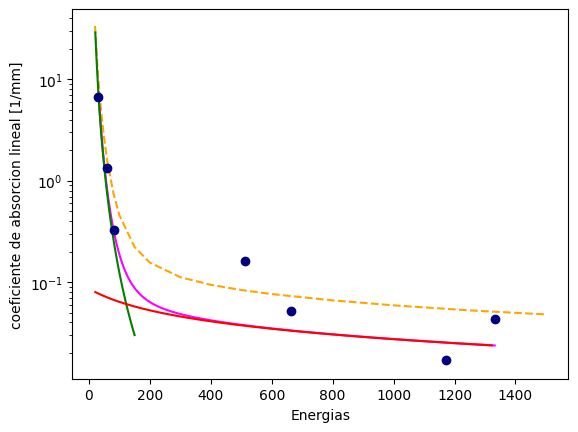

In [74]:
popt_FC,cov_FC = curve_fit(FC, Energias_mu_Int_new, Mu_L_Int_new, sigma= err_mu, bounds=([0, 0], [np.inf, np.inf]), p0=[4.38490287e-12,7.27147760e-03])
perr_FC = np.sqrt(np.diag(cov_FC))

print(popt_FC)
print(perr_FC)

uA=63.546
rho=8.96*(10**-3)


Continuo=np.linspace(Energias_mu_Int_new[0], Energias_mu_Int_new[len(Energias_mu_Int_new)-1], 1000)

plt.errorbar(Energias_mu_Int_new, Mu_L_Int_new, yerr=err_mu, fmt='o', color='navy', label=r'$\mu_{L(E)}$')
plt.semilogy(E_biblio, mu_biblio, color='orange', linestyle='dashed', label='Datos Bibliograficos')
plt.semilogy(Continuo, FC(Continuo, *popt_FC), color='magenta', label='Absorsión fotoeléctrica + dispersión')
plt.semilogy(Continuo[0:100]-10, photo(Continuo[0:100]-10, popt_FC[0]), color='green', label='Absorsión fotoeléctrica')
plt.semilogy(Continuo[:]-10, compton(Continuo[:]-10, popt_FC[1]), color='red', label='Dispersión')
plt.xlabel('Energias')
plt.ylabel('coeficiente de absorcion lineal [1/mm]')


Las secciones son de la forma:

$\sigma=const_{ph}*f_{ph(k)}\\$
$\tau=const_C*f_{C(k)}\\$

$[const_ph]=[const_C]=[mm^2]$

Donde conocemos el valor de cada constante (forlanski). El modelo es que planteamos es entonces:

$\mu_L=\frac{\rho [g/mm3]}{masa atomica[g]}*(\sigma+\tau)[mm2]$

El ajuste, por otro lado, es sobre las constantes a y b que acompañan a las funciones $f_{(k)}$:

$\mu_L=a*f_{ph(k)}+b*f_{C(k)} \quad ; \quad [f]=Ad \quad [a]=[b]=\frac{1}{mm}$

Por lo tanto, las constantes de proporcionalidad adimensionales vienen dadas por:

$\mu_L=\frac{\rho}{uA}*(\frac{uA}{\rho}\frac{a}{const_{ph}}\sigma+\frac{uA}{\rho}\frac{b}{const_C}\tau)[mm2]$

De modo que las constantes que ahora acompañan a las secciones son adimensionales:

$A=\frac{uA}{\rho}\frac{a}{const_{ph}} \quad ; \quad [A]=\frac{[uA]}{[\rho]}\frac{[a]}{[const_ph]}=\frac{[g]}{[\frac{g}{mm^3}]}\frac{[\frac{1}{mm}]}{[mm^2]}=[AU]$

Text(0, 0.5, 'Coeficiente de absorsión másico [mm2/g]')

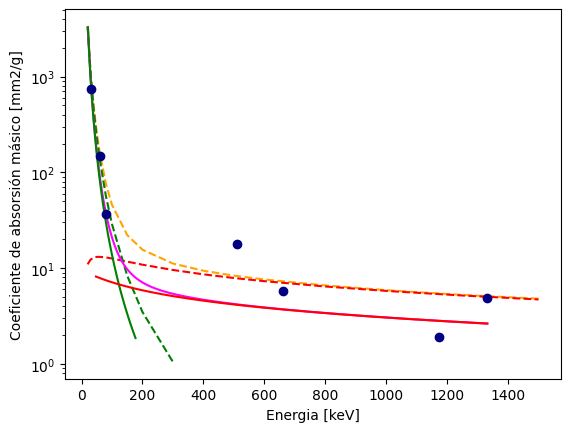

In [87]:
const_tau=2*np.pi*29*(0.07941*10**(-22)) #Constante que acompaña a la funcion f(k) para Compton
const_sigma=(5.34*10**(-31)) #Constante que acompaña a la funcion f(k) para Fotoelectrico

uA=63.546
rho=8.96*(10**-3)

Ad_ph=(popt_FC[0]/const_sigma)*(uA/rho)
Ad_C=(popt_FC[1]/const_tau)*(uA/rho)

def seccion_compton(x):
    k=x/511
    tau=const_tau*(((((1+k)/(k)**2)*((2*(1+k)/(1+2*(k)))-np.log(1+2*(k))/(k))))+np.log(1+2*(k))/(2*(k))-(1+3*(k))/(1+2*(k))**2)
    return tau

def seccion_foto(x):
    k=x/511
    sigma=const_sigma*29**5/((k)**(3.5))
    return sigma

def contribuciones_seccion(x,A,B):

    return A*seccion_foto(x)+B*seccion_compton(x)

Mu_masico=Mu_L_Int_new*(1/rho)

Continuo=np.linspace(Energias_mu_Int_new[0]-10, Energias_mu_Int_new[len(Energias_mu_Int_new)-1], 1000)

plt.errorbar(Energias_mu_Int_new, Mu_masico, yerr=err_mu, fmt='o', color='navy', label=r'$\mu_{L(E)}$')
plt.semilogy(E_biblio_2, at_total, color='orange', linestyle='dashed', label='Atenuacion total biblio')
plt.semilogy(E_biblio_2, Compton_dat, color='red', linestyle='dashed', label='Atenuacion compton biblio')
plt.semilogy(E_biblio_2[:10], fotoelectrico[:10], color='green', linestyle='dashed', label='Absorsion fotoelectrico biblio')
plt.semilogy(Continuo, (1/uA)*contribuciones_seccion(Continuo, Ad_ph, Ad_C), color='magenta', label='Absorsión fotoeléctrica + dispersión')
plt.semilogy(Continuo[:120], (1/uA)*Ad_ph*seccion_foto(Continuo[:120]), color='green', label='Absorsión fotoeléctrica')
plt.semilogy(Continuo[20:], (1/uA)*Ad_C*seccion_compton(Continuo[20:]), color='red', label='Dispersión')
plt.xlabel('Energia [keV]')
plt.ylabel('Coeficiente de absorsión másico [mm2/g]')

In [71]:
porcentaje_foto=(Ad_ph*100)/(Ad_C+Ad_ph)
porcentaje_Compton=(Ad_C*100)/(Ad_ph+Ad_C)

print('El porcentaje de fotoeléctrico es: ', porcentaje_foto)
print('El porcentaje de Compton es: ', porcentaje_Compton)

El porcentaje de fotoeléctrico es:  45.61970872835215
El porcentaje de Compton es:  54.38029127164785


# Plot

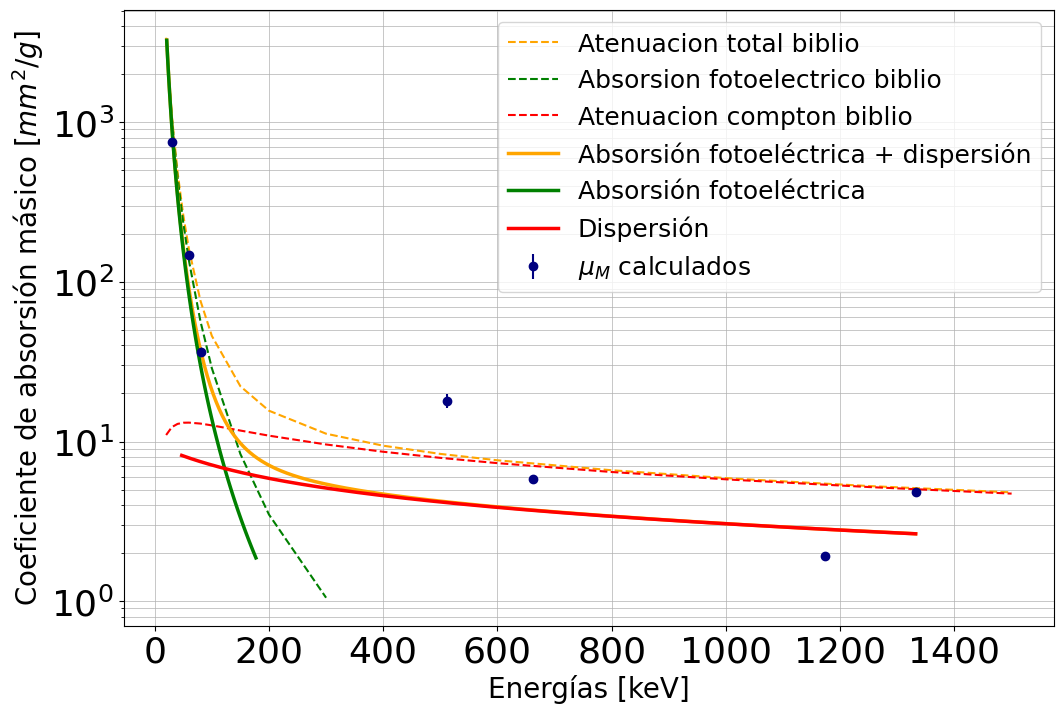

In [92]:
plt.figure(figsize=(12,8))

plt.errorbar(Energias_mu_Int_new, Mu_masico, yerr=err_mu*(1/rho), fmt='o', color='navy', label=r'$\mu_M$ calculados')
plt.semilogy(E_biblio_2, at_total, color='orange', linestyle='dashed', label='Atenuacion total biblio')
plt.semilogy(E_biblio_2[:10], fotoelectrico[:10], color='green', linestyle='dashed', label='Absorsion fotoelectrico biblio')
plt.semilogy(E_biblio_2, Compton_dat, color='red', linestyle='dashed', label='Atenuacion compton biblio')
plt.semilogy(Continuo, (1/uA)*contribuciones_seccion(Continuo, Ad_ph, Ad_C), linewidth=2.5, color='orange', label='Absorsión fotoeléctrica + dispersión')
plt.semilogy(Continuo[:120], (1/uA)*Ad_ph*seccion_foto(Continuo[:120]), linewidth=2.5, color='green', label='Absorsión fotoeléctrica')
plt.semilogy(Continuo[20:], (1/uA)*Ad_C*seccion_compton(Continuo[20:]), linewidth=2.5, color='red', label='Dispersión')

plt.grid(linewidth=0.5, which='both')
plt.xlabel(r'Energías [keV]', fontsize=20)
plt.ylabel(r'Coeficiente de absorsión másico $[mm^2/g]$', fontsize=20)
plt.legend(fontsize=18)
plt.xticks(fontsize=26)
plt.yticks(fontsize=26)

plt.savefig('Efectos.jpg', format='jpg', dpi=1000, bbox_inches='tight')